For DYNAMIC Peak count and depolarization start times

version 6 changelist: 
- Photobleaching over time correction via identification of "flat" regions in traces, interpolating a bleach curve, and dividing the smoothed signal by that curve
- Slope via gradient instead of Savitzky-Golay filter derivative
- Thresholds computed after applying bleaching correction
- Changed filter to remove peaks with upstroke of 0.06 duration or longer vs 0.02 as in previous version (fixes overlapping depol/peaks)
- Filter out outlier APD90 ≥ 1.8× median to reduce combined APD90s

QUESTIONS?: huynh.trung@mayo.edu


,Sample,ROI,Depolarization_Start_Time_s,Peak_Time_s,Amplitude,APD50_s,APD90_s,APD50_90_Ratio,Upstroke_Time_s,Repolarization_Time_s,Repolarization_Level
0,CRISPH222P_PreISO011,#1 (Mono - Tx Red),0.310,0.440,0.009231,0.280,0.401,0.698254,0.130,0.711,0.002710
1,CRISPH222P_PreISO011,#1 (Mono - Tx Red),0.781,0.911,0.009286,0.230,0.300,0.766667,0.130,1.081,0.002900
2,CRISPH222P_PreISO011,#1 (Mono - Tx Red),1.201,1.331,0.009201,0.290,0.390,0.743590,0.130,1.591,0.002866
3,CRISPH222P_PreISO011,#1 (Mono - Tx Red),1.691,1.781,0.009142,0.231,0.321,0.719626,0.090,2.012,0.002683
4,CRISPH222P_PreISO011,#1 (Mono - Tx Red),2.132,2.242,0.009713,0.280,0.350,0.800000,0.110,2.482,0.002861
5,CRISPH222P_PreISO011,#1 (Mono - Tx Red),2.632,2.742,0.009716,0.240,0.320,0.750000,0.110,2.952,0.002851
6,CRISPH222P_PreISO011,#1 (Mono - Tx Red),3.082,3.182,0.009944,0.281,0.371,0.757412,0.100,3.453,0.002593
7,CRISPH222P_PreISO011,#1 (Mono - Tx Red),3.553,3.683,0.010022,0.250,0.370,0.675676,0.130,3.923,0.002751
8,CRISPH222P_PreISO011,#1 (Mono - Tx Red),3.983,4.113,0.009302,0.290,0.370,0.783784,0.130,4.353,0.002851
9,CRISPH222P_PreISO011,#1 (Mono - Tx Red),4.443,4.584,0.009821,0.261,0.351,0.743590,0.141,4.794,0.003011


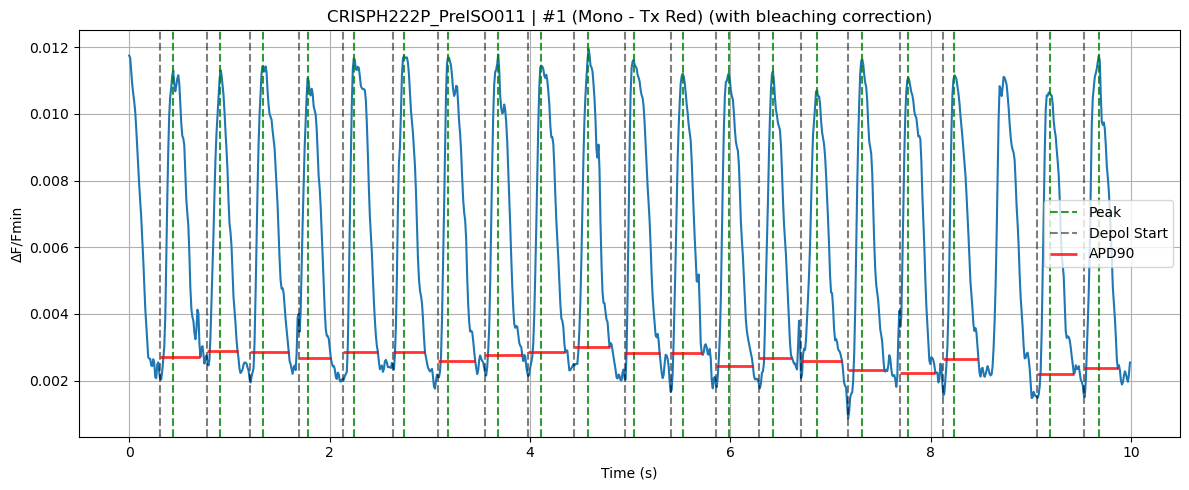

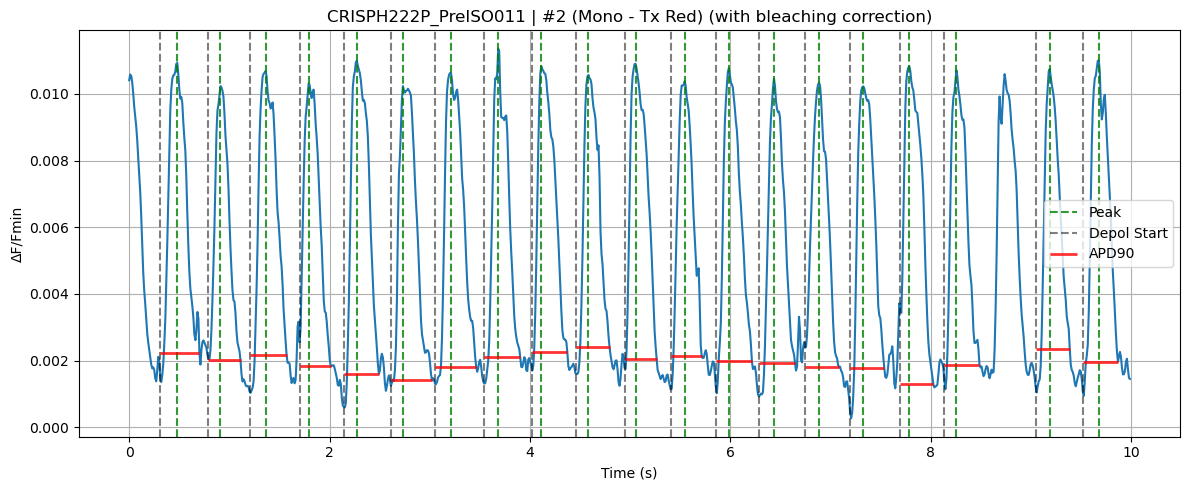

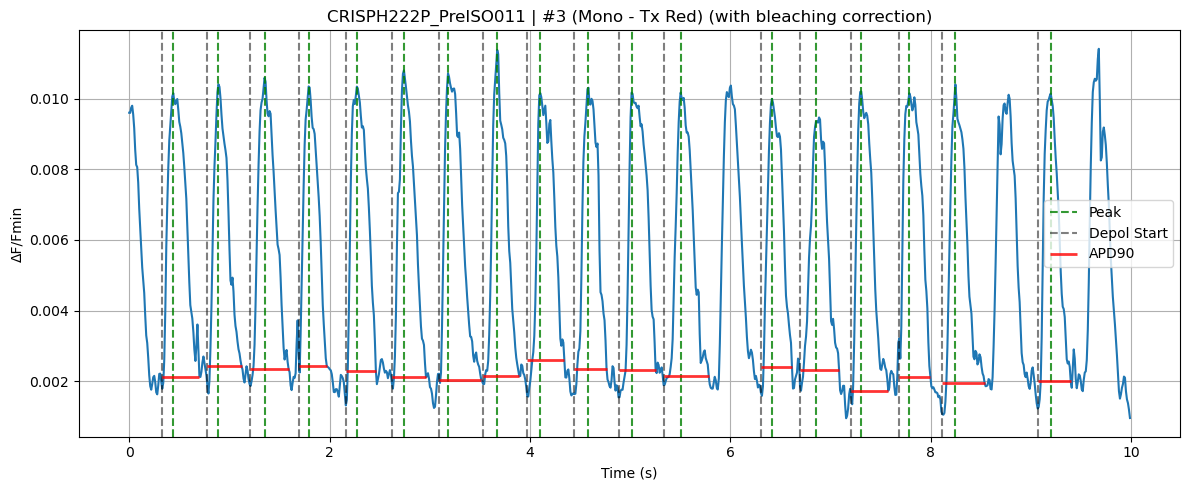

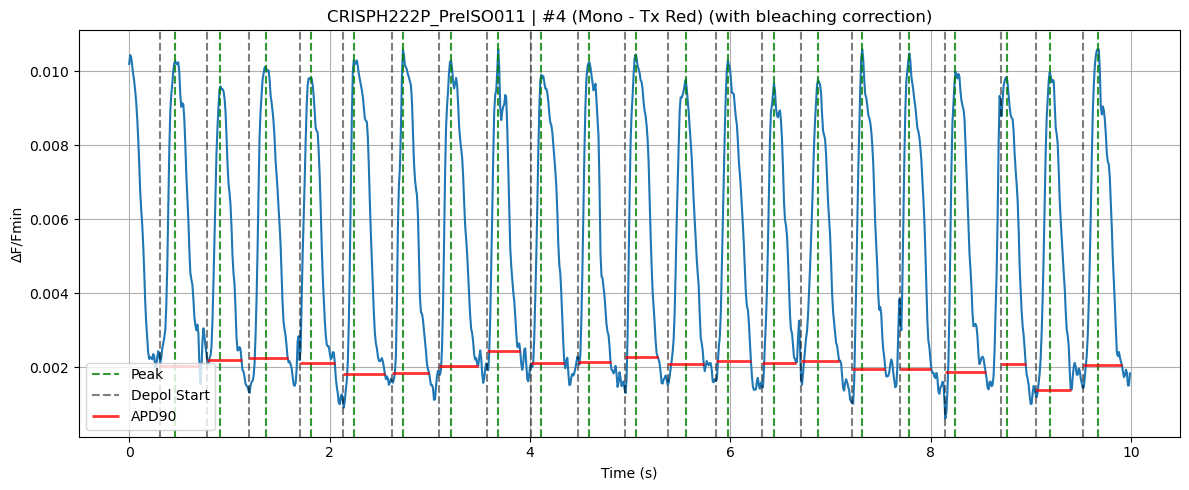

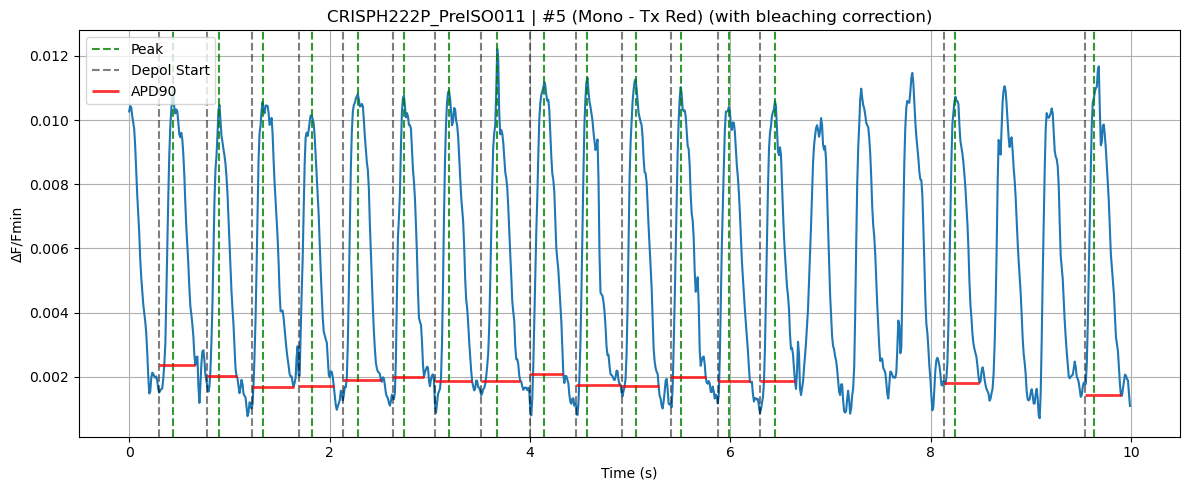

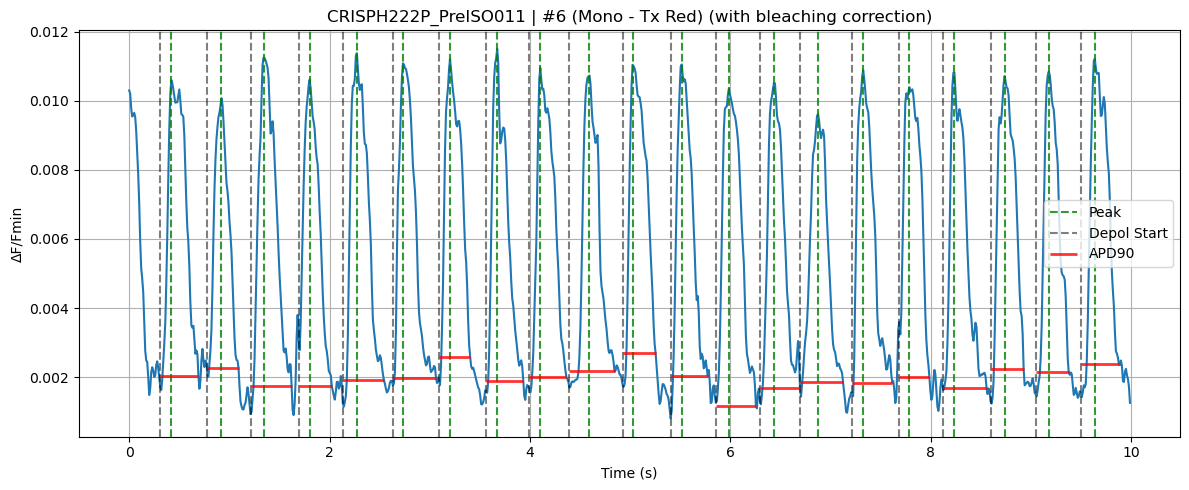

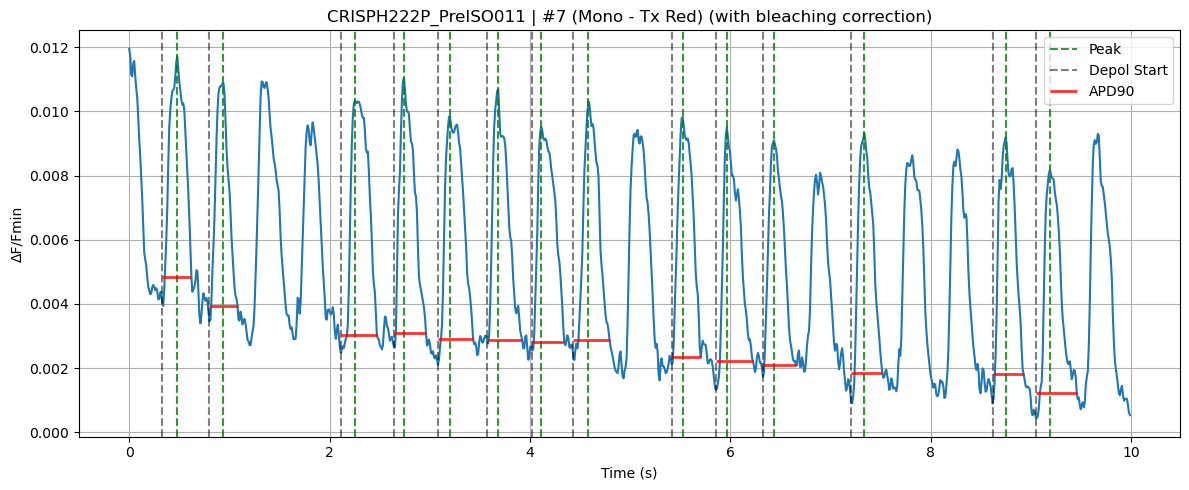

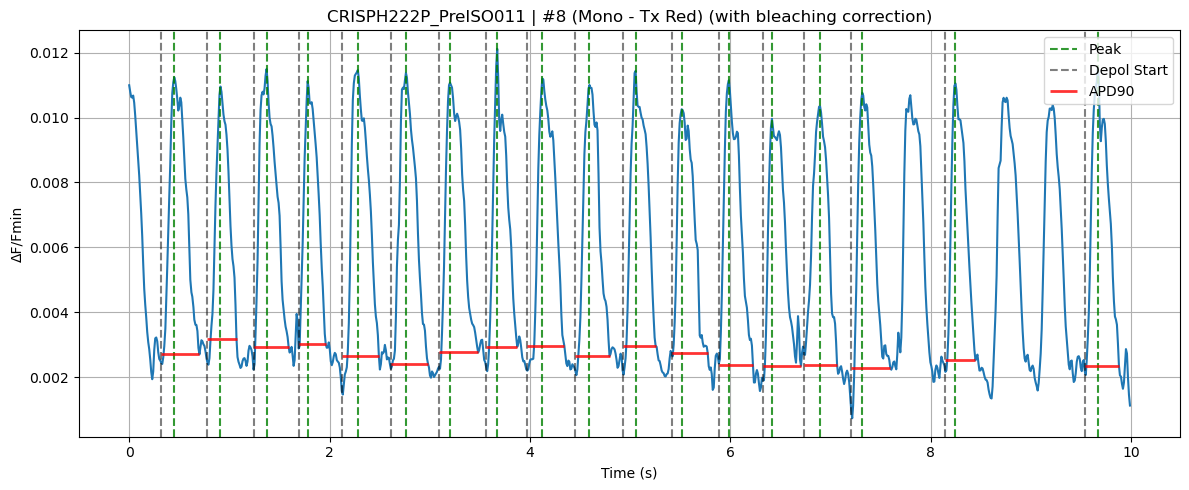

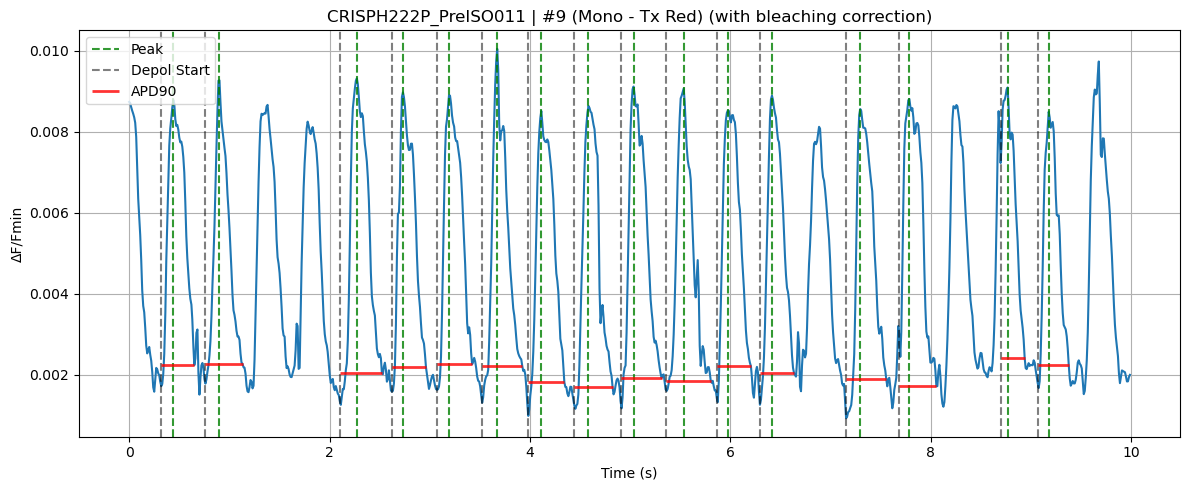

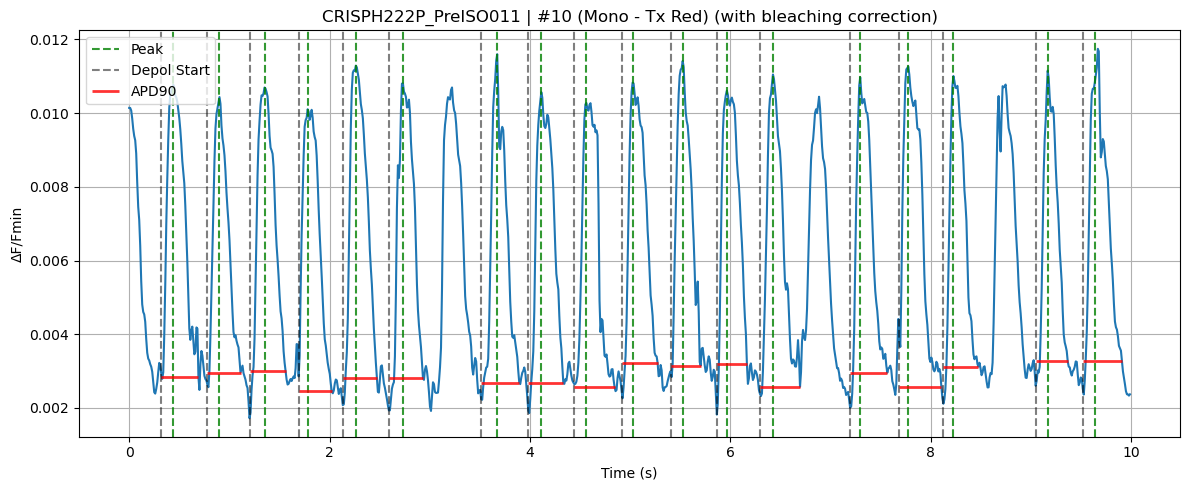

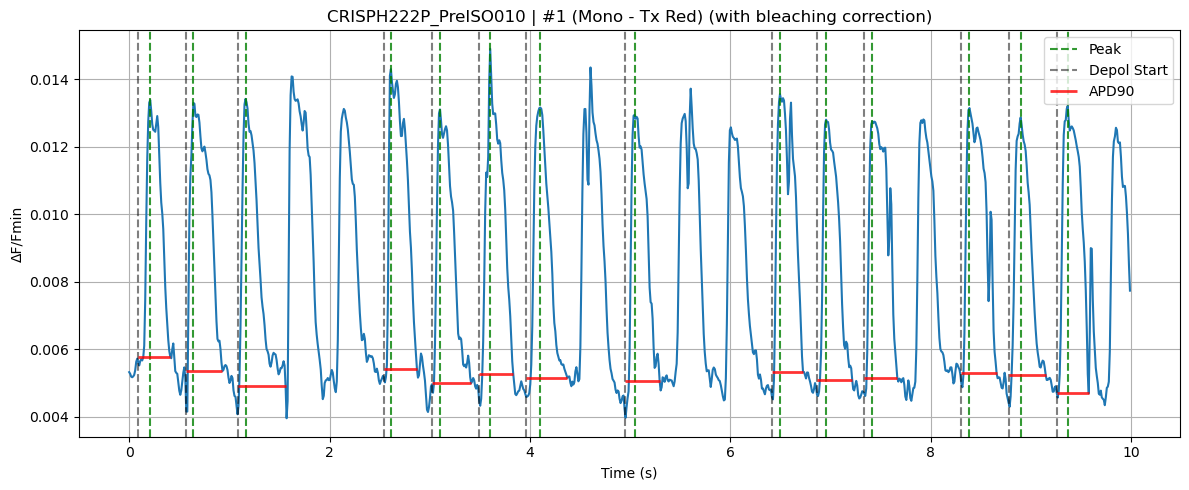

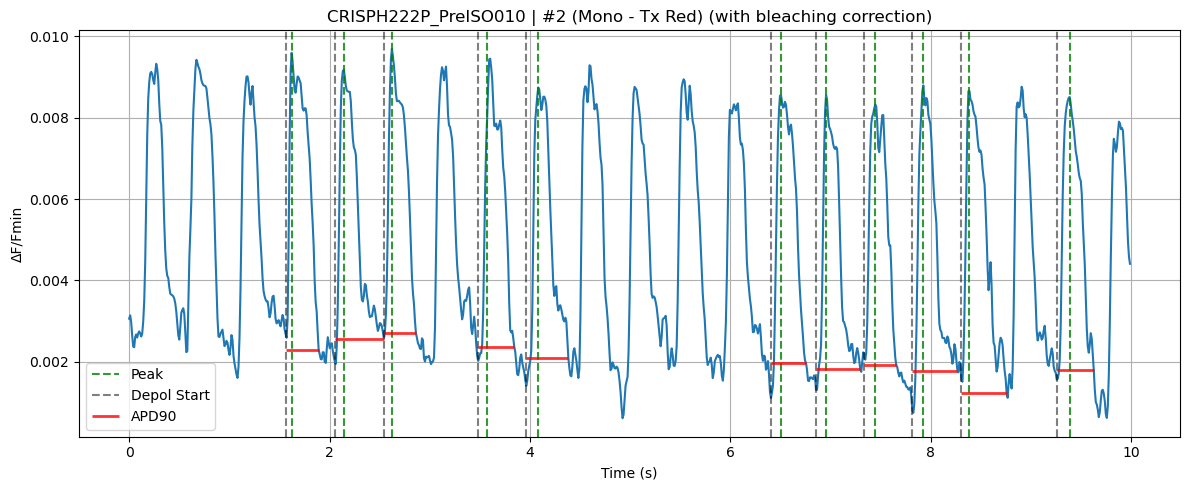

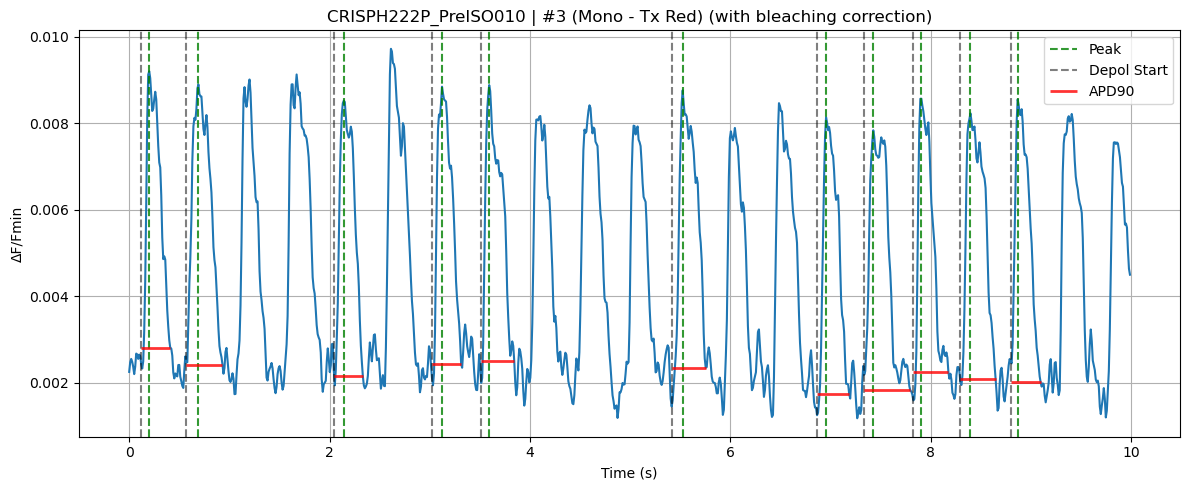

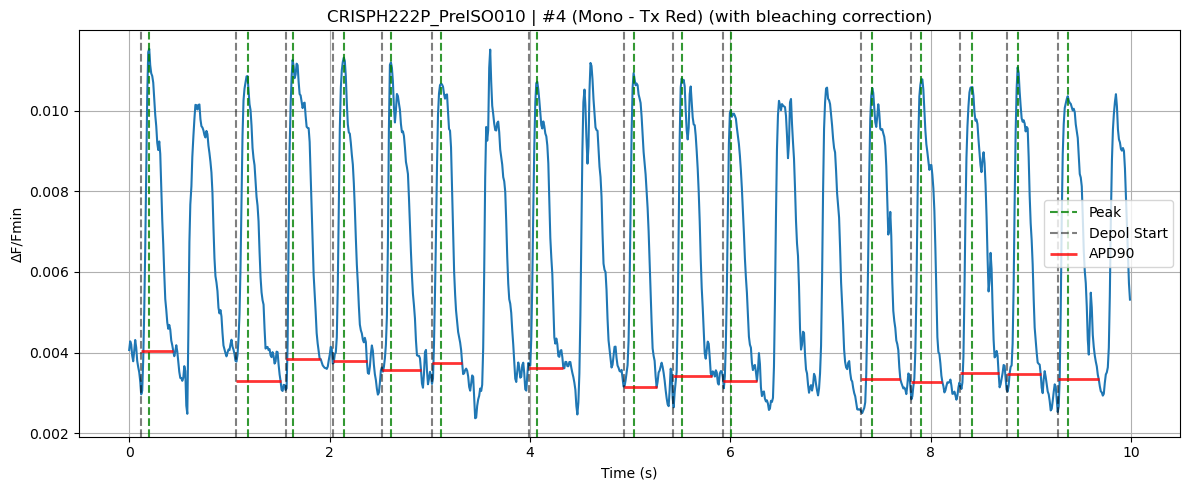

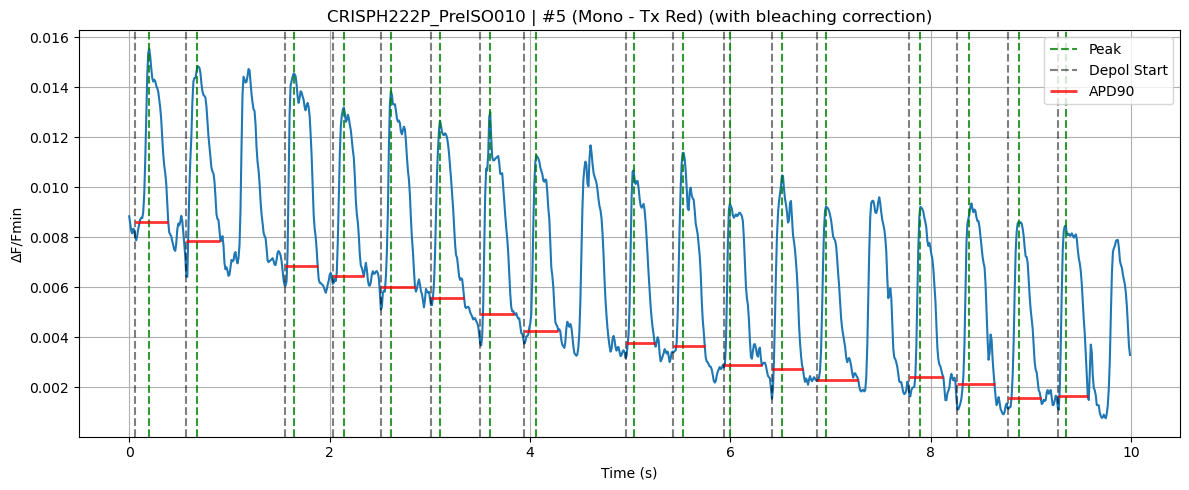

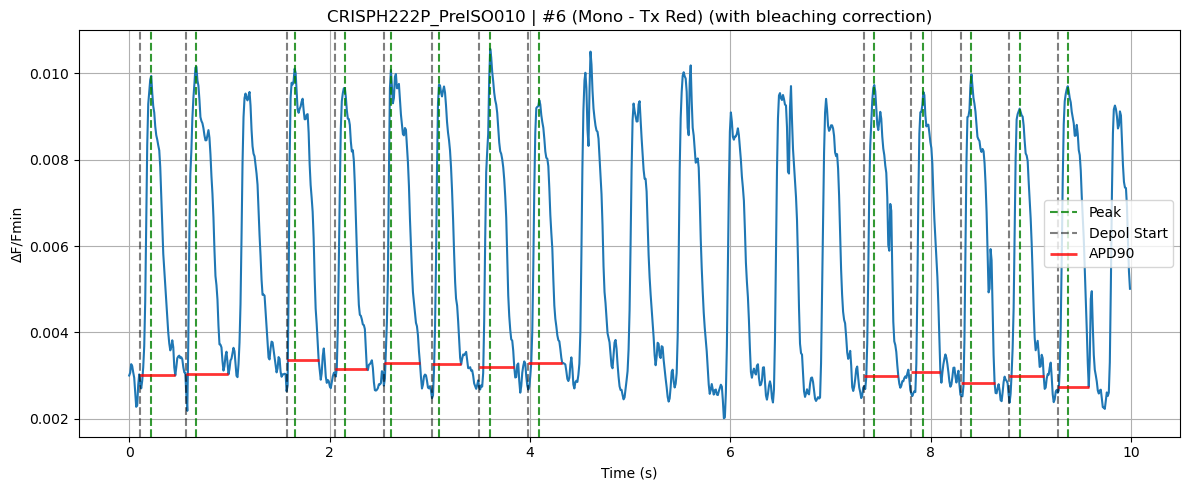

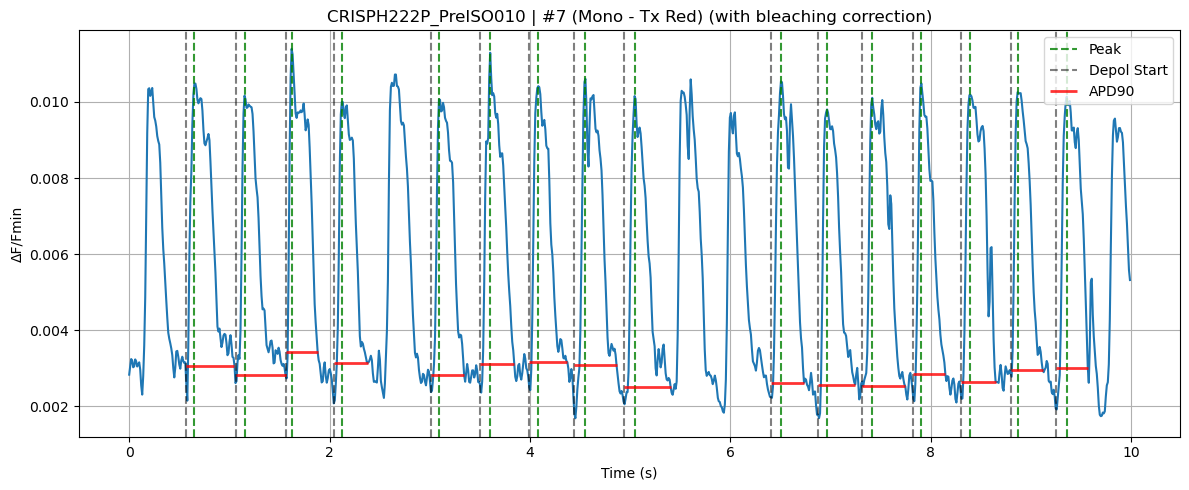

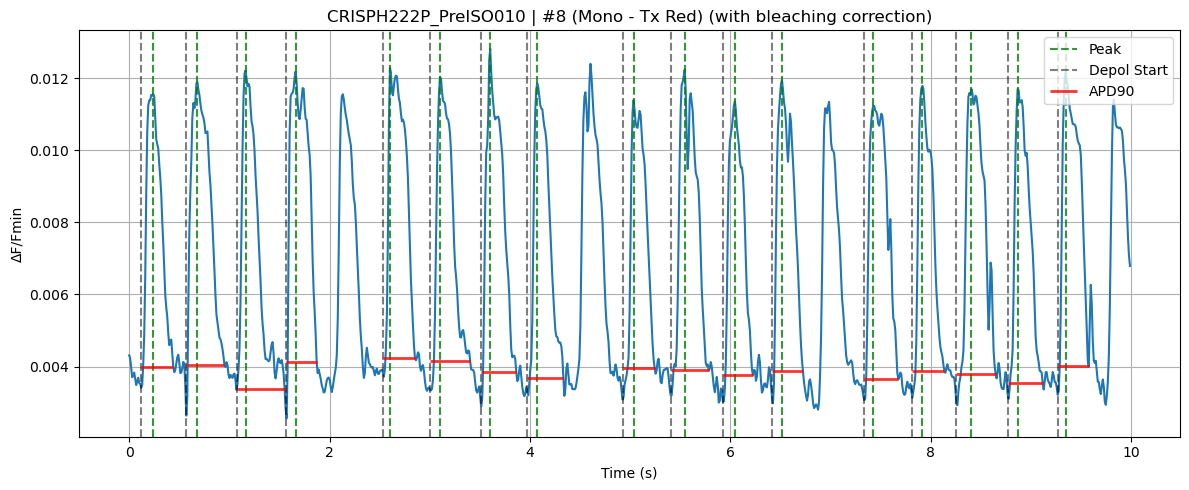

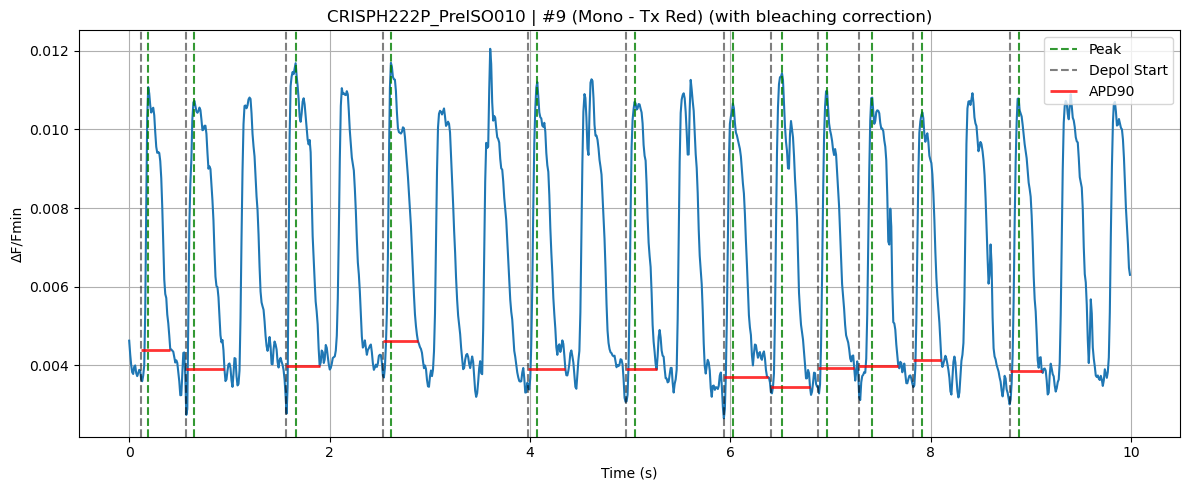

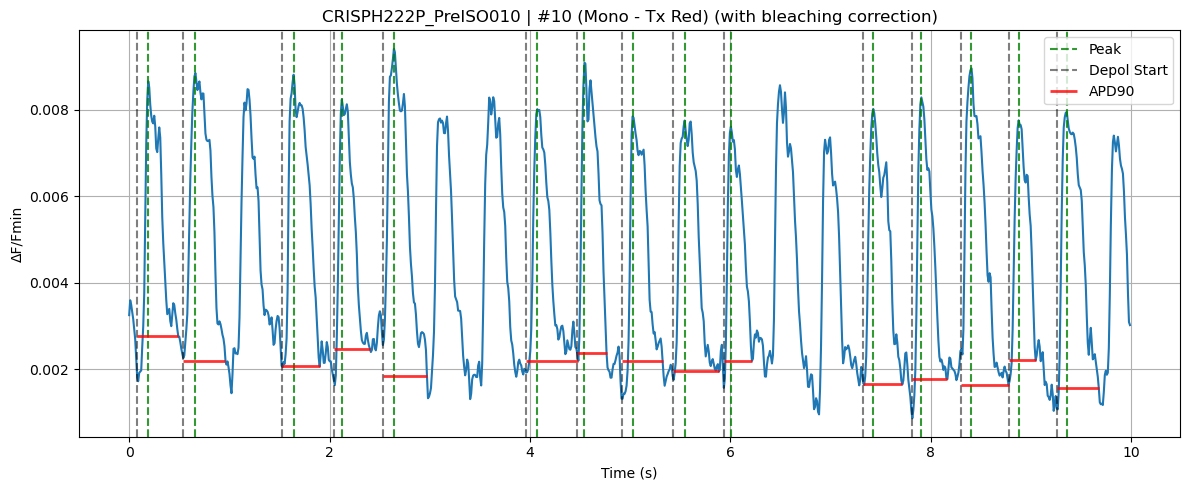

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from itertools import groupby
from operator import itemgetter

# === Step 0: Path to your Excel file ===
excel_path = "C:\\Users\\m254292\\Downloads\\Sup Rep BeRST pilot excel.xlsx"

# === Step 1: Load workbook ===
xls = pd.ExcelFile(excel_path)

# === Step 2: Define your analysis function ===
def analyze_roi_signal(time, signal, sample_name, roi_label):
    # Clean and prepare
    signal = pd.to_numeric(signal, errors='coerce').dropna().values
    time = time[: len(signal)]

    # Normalize ΔF/Fmin
    Fmin = np.min(signal)
    normalized = (signal - Fmin) / Fmin

    # Smooth
    smoothed = gaussian_filter1d(normalized, sigma=1)

        # --- Compute slope via numerical derivative to avoid SVD errors ---
    slope_initial = np.gradient(smoothed, time)

    # --- Photobleaching correction via flat points ---
    flat_thresh = np.percentile(np.abs(slope_initial), 20)
    flat_idxs = np.where(np.abs(slope_initial) < flat_thresh)[0]
    if flat_idxs.size >= 2:
        flat_times = time[flat_idxs]
        flat_vals = smoothed[flat_idxs]
        bleach_curve = np.interp(time, flat_times, flat_vals)
        bleach_curve[bleach_curve == 0] = 1
        smoothed = smoothed / bleach_curve

    # Dynamic thresholds on corrected signal
    s_max, s_med = np.max(smoothed), np.median(smoothed)
    dr = s_max - s_med
    rising_thresh = 0.05 * dr
    depol_thresh = 0.02 * dr

        # --- Recompute slope via numerical derivative to avoid SVD errors ---
    slope = np.gradient(smoothed, time)

    # Detect rising-edge groups
    edges = np.where(slope > rising_thresh)[0]
    groups = []
    for k, g in groupby(enumerate(edges), lambda x: x[0] - x[1]):
        grp = [i for _, i in g]
        if len(grp) >= 5:
            groups.append(grp)

    # Candidate peaks
    peeks = []
    for grp in groups:
        start = grp[0]
        end = min(grp[-1] + 20, len(smoothed))
        peeks.append(np.argmax(smoothed[start:end]) + start)

    # De-dupe close peaks
    filt_peeks = []
    for p in peeks:
        if not filt_peeks or p - filt_peeks[-1] > 40:
            filt_peeks.append(p)

    # Extract metrics
    results = []
    for pk in filt_peeks:
        window = range(max(0, pk - 100), pk)
        cand = [i for i in window if slope[i] < depol_thresh]
        if not cand:
            continue

        start_idx = cand[-1]
        pre = smoothed[max(0, start_idx - 50) : start_idx]
        baseline = np.min(pre)

        peak_val = smoothed[pk]
        amp = peak_val - baseline

        # APD90
        lvl90 = baseline + 0.1 * amp
        repol90_idx = next(
            (i for i in range(pk + 1, len(smoothed)) if smoothed[i] <= lvl90),
            None,
        )
        if repol90_idx is None:
            continue
        repol90_time = time[repol90_idx]
        repol90_level = smoothed[repol90_idx]
        apd90 = repol90_time - time[start_idx]

        # APD50
        lvl50 = baseline + 0.5 * amp
        repol50_idx = next(
            (i for i in range(pk + 1, len(smoothed)) if smoothed[i] <= lvl50),
            None,
        )
        if repol50_idx is None:
            continue
        apd50 = time[repol50_idx] - time[start_idx]

        ratio50_90 = apd50 / apd90 if apd90 > 0 else np.nan
        upstroke = time[pk] - time[start_idx]

        results.append(
            {
                'Depolarization_Start_Time_s': time[start_idx],
                'Peak_Time_s': time[pk],
                'Amplitude': amp,
                'APD50_s': apd50,
                'APD90_s': apd90,
                'APD50_90_Ratio': ratio50_90,
                'Upstroke_Time_s': upstroke,
                'Repolarization_Time_s': repol90_time,
                'Repolarization_Level': repol90_level,
            }
        )

    df_res = pd.DataFrame(results)

    # Filter Section
    if not df_res.empty:
        #Filter out fast upstrokes to reduce overlapping depols/peaks
        df_res = df_res[df_res['Upstroke_Time_s'] > 0.06].reset_index(drop=True)  ## v6 changed 0.02 to 0.06

        # Filter out outlier APD90 ≥ 1.8× median to reduce combined APD90s──────────── ## v6 NEW
        median_apd90 = df_res['APD90_s'].median()
        df_res = df_res[df_res['APD90_s'] < 1.8 * median_apd90].reset_index(drop=True)

    # Ensure columns
    expected = [
        'Depolarization_Start_Time_s',
        'Peak_Time_s',
        'Amplitude',
        'APD50_s',
        'APD90_s',
        'APD50_90_Ratio',
        'Upstroke_Time_s',
        'Repolarization_Time_s',
        'Repolarization_Level',
    ]
    df_res = df_res.reindex(columns=expected)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(time, smoothed)
    for i, t in enumerate(df_res['Peak_Time_s']):
        ax.axvline(
            t, color='green', linestyle='--', alpha=0.8, label='Peak' if i == 0 else None
        )
    for i, t in enumerate(df_res['Depolarization_Start_Time_s']):
        ax.axvline(
            t,
            color='black',
            linestyle='--',
            alpha=0.5,
            label='Depol Start' if i == 0 else None,
        )
    for i, row in enumerate(df_res.itertuples()):
        ax.hlines(
            y=row.Repolarization_Level,
            xmin=row.Depolarization_Start_Time_s,
            xmax=row.Repolarization_Time_s,
            color='red',
            linestyle='-',
            linewidth=2,
            alpha=0.8,
            label='APD90' if i == 0 else None,
        )
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("ΔF/Fmin")
    ax.set_title(f"{sample_name} | {roi_label} (with bleaching correction)")
    ax.grid(True)
    fig.tight_layout()

    return sample_name, roi_label, df_res, fig

# === Main loop ===
all_results = []
plots = []
for sheet_name in xls.sheet_names:
    raw = xls.parse(sheet_name, header=None, nrows=1)
    if raw.dropna(how='all').empty:
        continue
    sample_name = str(raw.iloc[0, 0])
    if sample_name.lower().endswith('.nd2'):
        sample_name = sample_name[:-4]

    df = xls.parse(sheet_name, header=1)
    if df.dropna(how='all').empty:
        continue
    df.columns = df.columns.astype(str).str.strip()

    time_cols = [c for c in df.columns if 'time' in c.lower()]
    if not time_cols:
        continue
    time = pd.to_numeric(df[time_cols[0]], errors='coerce').values

    roi_cols = [c for c in df.columns if c != time_cols[0] and 'Mono' in c]
    for roi in roi_cols:
        samp, roi_label, res_df, fig = analyze_roi_signal(
            time, df[roi], sample_name, roi
        )
        res_df.insert(0, 'Sample', samp)
        res_df.insert(1, 'ROI', roi_label)
        all_results.append(res_df)
        plots.append((samp, roi_label, fig))

if all_results:
    summary_df = pd.concat(all_results, ignore_index=True)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(summary_df)
else:
    print("No data found in any sheets.")


In [29]:
import os
import io

# === After you’ve built `all_results` and `summary_df` ===
# (and assuming you modified analyze_roi_signal to return the Figure object:)
#
# e.g. def analyze_roi_signal(...):
#       …
#       fig, ax = plt.subplots(figsize=(12,5))
#       ax.plot(...)
#       … 
#       return sample_name, roi_label, df_res, fig
#
# And in your loop you collected:
#    plots = []  # list of (sample, roi, fig)
#    for …:
#        samp, roi, df_res, fig = analyze_roi_signal(...)
#        plots.append((samp, roi, fig))
#        # insert sample/ROI into df_res as before
#        all_results.append(df_res)
#
# At this point you have:
#    summary_df  ← pd.concat(all_results)
#    plots       ← list of (sample, roi, fig)

# === Dynamically build out_path using os.path (Option 1) ===
folder, basename = os.path.split(excel_path)
name, ext       = os.path.splitext(basename)
new_name        = f"{name} batch analysis{ext}"
out_path        = os.path.join(folder, new_name)

# === Write summary_df and plots into the new workbook ===
with pd.ExcelWriter(out_path, engine='xlsxwriter') as writer:
    # 1) summary table
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

    # 2) embed plots
    workbook  = writer.book
    worksheet = workbook.add_worksheet('Plots')

    img_row = 0
    for sample, roi, fig in plots:
        buf = io.BytesIO()
        fig.savefig(buf, format='png', dpi=150, bbox_inches='tight')
        buf.seek(0)

        worksheet.write(img_row, 0, f"{sample} | {roi}")
        img_row += 1

        worksheet.insert_image(
            img_row, 0,
            f"{sample}_{roi}.png",
            {'image_data': buf, 'x_scale': 0.8, 'y_scale': 0.8}
        )
        img_row += 30

print(f"✅ Saved batch analysis to:\n  {out_path}")

✅ Saved batch analysis to:
  C:\Users\m254292\Downloads\Annabel Fluovolt Data batch analysis.xlsx


To Do: 
- Add APD50
- Add ratio of APD50/90
